# Requirements

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from scipy.stats import pearsonr

import nltk

import sddk

# PLOTTING
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import geoplot as gplt

In [114]:
s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")
figpath = "SDAM_data/social_diversity/socdiv_figures/"

# global parameters for plots
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    #each figure to be saved in four different versions
    fig.savefig("../figures/" + fig_name + ".eps", format="eps")
    fig.savefig("../figures/" + fig_name + ".png")
    s.write_file(figpath + fig_name + ".eps", fig)
    s.write_file(figpath + fig_name + ".png", fig)

connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


# Import datasets

In [4]:
file_data = s.read_file("https://sciencedata.dk/files/ServiceAccountsKey.json", "dict")
credentials = service_account.Credentials.from_service_account_info(file_data)
gc = gspread.Client(auth=credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']))
socdiv_results = gc.open_by_url("https://docs.google.com/spreadsheets/d/1kACGBS9Xdno7FL2fPZ-vCOu4SSh9uUaZmGvnEghVs_A/edit?usp=sharing")

In [2]:
LIRE = gpd.read_parquet("../data/large_data/LIRE_occupsorgs_cats.parquet")

In [3]:
# mask
before235 = LIRE["not_before"] < 235

In [4]:
LIRE[LIRE["is_western"]]

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats
210,EDCS-21300235,"CIL 06, 00882 (p 3777, 4302, 4367) = CIL 06, 3...",Aegyptus,Aegyptus,Al Iskandariyah / Alexandria,"['Al Iskandariyah', 'Alexandria']",20,,"['Augusti/Augustae', 'tituli sacri', 'viri']",tituli sacri,...,9998.65,1002,"[12.395451, 42.021684]",15756.86,large,[faber],1,[],0,"[Production and related workers, transport equ..."
281,EDCS-12800362,"AE 1964, 00222",Aemilia / Regio VIII,Aemilia / Regio VIII,Bagno di Romagna,Bagno di Romagna,200,,"['tituli sacri', 'viri']",tituli sacri,...,41767.45,937,"[11.903398, 43.983123]",17068.12,rural,[],0,[],0,[]
282,EDCS-09300206,"AE 1976, 00204",Aemilia / Regio VIII,Aemilia / Regio VIII,Bologna / Bononia,"['Bologna', 'Bononia']",50,,"['mulieres', 'tituli sepulcrales', 'tria nomin...",tituli sepulcrales,...,330.60,1012,"[11.470525, 44.443585]",11359.10,medium,[],0,[],0,[]
283,EDCS-09300210,"AE 1976, 00208",Aemilia / Regio VIII,Aemilia / Regio VIII,Bologna / Bononia,"['Bologna', 'Bononia']",50,,"['liberti/libertae', 'mulieres', 'tituli sepul...",tituli sepulcrales,...,330.60,1012,"[11.470525, 44.443585]",11359.10,medium,[],0,[],0,[]
284,EDCS-09300215,"AE 1976, 00213",Aemilia / Regio VIII,Aemilia / Regio VIII,Bologna / Bononia,"['Bologna', 'Bononia']",100,,"['mulieres', 'tituli sepulcrales', 'tria nomin...",tituli sepulcrales,...,330.60,1012,"[11.470525, 44.443585]",11359.10,medium,[],0,[],0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136185,EDCS-10700071,"SupIt-12-IC, 00047 = IulCarnicum-02, 00125",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Zuglio / Iulium Carnicum,"['Zuglio', 'Iulium Carnicum']",200,,{ },{ },...,79599.13,1054,"[13.025796, 46.460796]",112.68,small,[],0,[],0,[]
136186,EDCS-10700072,"SupIt-12-IC, 00048 = IulCarnicum-02, 00137",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Zuglio / Iulium Carnicum,"['Zuglio', 'Iulium Carnicum']",200,,{ },{ },...,79599.13,1054,"[13.025796, 46.460796]",112.68,small,[],0,[],0,[]
136187,EDCS-10700073,"SupIt-12-IC, 00049 = IulCarnicum-02, 00134",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Zuglio / Iulium Carnicum,"['Zuglio', 'Iulium Carnicum']",200,,{ },{ },...,79599.13,1054,"[13.025796, 46.460796]",112.68,small,[],0,[],0,[]
136188,EDCS-10700074,"SupIt-12-IC, 00050 = IulCarnicum-02, 00115",Venetia et Histria / Regio X,Venetia et Histria / Regio X,Zuglio / Iulium Carnicum,"['Zuglio', 'Iulium Carnicum']",25,,{ },{ },...,79599.13,1054,"[13.025796, 46.460796]",112.68,small,[],0,[],0,[]


In [5]:
LIRE.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"['Agios Athanasios', 'Photike']",313,,"['Augusti/Augustae', 'litterae erasae', 'ordo ...",tituli honorarii,...,37687.28,31,"[20.787767, 39.546432]",10725.84,rural,[],0,[],0,[]
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",276,to 276; b: 276 to 282 \n\n,"['Augusti/Augustae', 'miliaria', 'viri']",miliaria,...,23430.85,73,"[22.336587, 37.462155]",7876.09,large,[],0,[],0,[]
2,EDCS-28500283,"CIL 03, 07251 = D 00214 = NDIEC-07, p 81 = AE ...",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",50,,"['Augusti/Augustae', 'leges', 'viri']",leges,...,23430.85,73,"[22.336587, 37.462155]",7876.09,large,[],0,[],0,[]
3,EDCS-09400671,"CIMRM-02, 02350 = IG-12, 00274 = Andros 00124 ...",Achaia,Achaia,Andros,Andros,209,,"['litterae erasae', 'tituli sacri']",tituli sacri,...,60414.04,47,"[24.34625, 37.633122]",47547.59,rural,[],0,[],0,[]
4,EDCS-24600769,"AE 1995, 01407 = AE 2001, 01812",Achaia,Achaia,Archea Olimpia / Archaia Olympia / Olympia,"['Archea Olimpia', 'Archaia Olympia', 'Olympia']",96,,{ },{ },...,45272.69,35,"[21.435443, 37.827452]",26125.55,large,[],0,[],0,[]


In [6]:
len(LIRE[before235])

114898

In [7]:
LIRE[before235]["occups_N"].sum()

4751

In [8]:
LIRE[before235]["occups_N"].sum() / LIRE["occups_N"].sum()

0.9168274797375531

In [9]:
roman_cities = gpd.read_file("../data/roman_cities_pop.geojson")
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson")
pleiades_regions_west = gpd.read_file("../data/pleiades_regions_west.geojson")

# Map inscriptions on cities

In [10]:
def get_my_city(row):
    context = row["urban_context_alt"]
    try:
        ID = row[context + "_city_ID"]
    except:
        ID = None
    return ID
LIRE["city_ID"] = LIRE.apply(lambda row: get_my_city(row), axis=1)

In [89]:
def get_inscriptions(ID):
    city_dict = {}
    city_data = LIRE[LIRE["city_ID"]==str(ID)]
    if len(city_data) > 0:
        city_dict["inscr_N"] = len(city_data)
        city_dict["occups_list"] = [el for sublist in city_data["occups"] for el in sublist]
        city_dict["occups_N"] = city_data["occups_N"].sum()
        city_dict["occups_cats_list"] = [el for sublist in city_data["occups_cats"] for el in sublist]
        city_dict["organizations_N"] = city_data["organizations_N"].sum()
        city_dict["organizations"] = [el for sublist in city_data["organizations"] for el in sublist]
    return city_dict

cities_dict_data = roman_cities["ID"].apply(get_inscriptions)

In [90]:
cities_inscr_data = pd.DataFrame(cities_dict_data.tolist())
cities_inscr_data.head(5)

,inscr_N,occups_list,occups_N,occups_cats_list,organizations_N,organizations
0,2.0,[],0.0,[],0.0,[]
1,2.0,[],0.0,[],0.0,[]
2,2.0,[],0.0,[],0.0,[]
3,1.0,[curator],1.0,[Administrative and managerial workers],0.0,[]
4,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
roman_cities = pd.concat([roman_cities, cities_inscr_data], axis=1)

In [92]:
del cities_inscr_data
del cities_dict_data

# Explore inscriptions within cities

In [93]:
roman_cities.head(5)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,inscr_N_log,pop_est_log10,inscr_N_log2,occups_N_log,inscr_N,occups_list,occups_N,occups_cats_list,organizations_N,organizations
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,[],0.0,[],0.0,[]
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,[],0.0,[],0.0,[]
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,[],0.0,[],0.0,[]
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,[curator],1.0,[Administrative and managerial workers],0.0,[]
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
# all cities
len(roman_cities)

1230

In [95]:
roman_cities["inscr_N"].sum()

inscr_N    102489.0
inscr_N    102489.0
dtype: float64

In [96]:
# cities with at least one inscription
(roman_cities["inscr_N"]>0).sum()

inscr_N    657
inscr_N    657
dtype: int64

In [97]:
# proportion of cities with at least one inscription
(roman_cities["inscr_N"]>0).mean()

inscr_N    0.534146
inscr_N    0.534146
dtype: float64

In [98]:
# N western cities
(roman_cities["western_province"]).sum()

889

In [99]:
((roman_cities["western_province"]) & (roman_cities["inscr_N"]>0)).sum()

TypeError: '<' not supported between instances of 'str' and 'int'

In [22]:
((roman_cities["western_province"]) & (roman_cities["inscr_N"]>0)).sum() / (roman_cities["western_province"]).sum()

0.7390326209223848

# Focus on western cities alone - basic explorations (feel free to skip)

In [23]:
roman_cities = roman_cities[roman_cities["western_province"]]
len(roman_cities)

889

In [24]:
roman_cities["pop_est_log"] = np.log(roman_cities["pop_est"])
roman_cities["inscr_N_log"] = np.log(roman_cities["inscr_N"])

roman_cities["pop_est_log10"] = np.log10(roman_cities["pop_est"])
roman_cities["inscr_N_log2"] = np.log2(roman_cities["inscr_N"])

roman_cities["occups_N_log"] = np.log2(roman_cities["occups_N"])


/Users/kasev/Projects/social_diversity/socdiv_venv/lib/python3.10/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Measuring Specialization and Diversity

In [25]:
len(roman_cities)

889

In [26]:
(roman_cities["occups_N"]>0).sum()

313

In [27]:
roman_cities["occups_N"].max()

1855.0

In [28]:
# roman cities western with at least one occupations
roman_cities_wo = roman_cities[roman_cities["occups_N"]>0].copy()

In [29]:
roman_cities_wo

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,inscr_with_occups,occups_mask,occups_list,occups_N,occups_cats_list,pop_est_log,inscr_N_log,pop_est_log10,inscr_N_log2,occups_N_log
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,1.0,"53855 True Name: occups_N, dtype: bool",[curator],1.0,[Administrative and managerial workers],6.907755,0.000000,3.000000,0.000000,0.000000
165,Hanson2016_166,Avitta,Henchir Bou Ftis,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,BNP; Boatwright 2000; Lepelley 1979-1981; Russ...,...,5.0,865 False 866 False 868 False 8...,"[scaenicus, curator, tonsor, possessor, faber]",5.0,"[Professional, technical and related workers, ...",8.905987,3.806662,3.867821,5.491853,2.321928
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,...,9.0,843 False 844 False 845 False 8...,"[curator, mesor, curator, mensor, agrimensor, ...",9.0,"[Administrative and managerial workers, Profes...",11.533453,6.161207,5.008915,8.888743,3.169925
174,Hanson2016_175,Clupea,Kelibia,Africa Proconsularis,Tunisia,4 or 5,32 H3,-310,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,...,1.0,"1094 False 1095 True Name: occups_N, dt...",[sartor],1.0,"[Agricultural, animal husbandry and forestry w...",6.907755,0.693147,3.000000,1.000000,0.000000
177,Hanson2016_178,Hadrumetum,Sousse,Africa Proconsularis,Tunisia,3,33 G1,-150,NaN,BNP; Brunt 1971; DGRG; Lepelley 1979-1981; Mac...,...,1.0,861 False 1100 False 1346 False 1...,"[faber, faber]",2.0,"[Production and related workers, transport equ...",10.480803,2.564949,4.551755,3.700440,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,Hanson2016_1298,Catania,Catania,Sicilia,Italy,3,47 G3,-729,NaN,Benario 1981; Brunt 1971; Cornell and Mathews ...,...,1.0,47894 False 47895 False 47896 Fals...,[faber],1.0,"[Production and related workers, transport equ...",10.247432,4.787492,4.450403,6.906891,0.000000
1311,Hanson2016_1312,Messana,Messina,Sicilia,Italy,3,47 H2,-730,NaN,Brunt 1971; Cornell and Mathews 1982; Hansen 2...,...,1.0,47899 False 47900 False 47901 Fals...,[faber],1.0,"[Production and related workers, transport equ...",9.351579,1.791759,4.061339,2.584963,0.000000
1315,Hanson2016_1316,Panormus,Palermo,Sicilia,Italy,2,47 C2,-700,NaN,Beloch 1886; BNP; Brunt 1971; Cornell and Math...,...,1.0,47902 False 127387 False 127388 Fals...,"[curator, curator]",2.0,"[Administrative and managerial workers, Admini...",8.521584,3.367296,3.700877,4.857981,1.000000
1317,Hanson2016_1318,Segesta,Segesta,Sicilia,Italy,3,47 B3,-600,NaN,McEvedy 2011; PECS; Sear 2006; Woloch 1983.,...,1.0,127226 False 127227 False 127228 Fals...,[forensis],1.0,[Administrative and managerial workers],8.405367,3.332205,3.650405,4.807355,0.000000


In [30]:
# generate a dictionary of occupations by type
occupations_df = pd.read_csv("../data/occupations_list_hisco.csv")
occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["Harris_Category"]))

In [31]:
print(len(set(occups_cats_dict.values())))
set(occups_cats_dict.values())

19


{'Building',
 'Clothing',
 'Death-care sector',
 'Education',
 'Finance',
 'Food-Production',
 'Food-Retail',
 'Fuel / Raw material',
 'Glass-Working',
 'Household Goods',
 'Managerial',
 'Metal-Working',
 'Miscellaneous Services',
 'Performing Arts',
 'Plastic Arts',
 'Retail',
 'Transport',
 'Unclear meaning',
 'Water-Management'}

In [32]:
occups_cats_labels = list(set(occups_cats_dict.values()))
occups_cats_labels

['Managerial',
 'Household Goods',
 'Water-Management',
 'Fuel / Raw material',
 'Plastic Arts',
 'Education',
 'Performing Arts',
 'Clothing',
 'Unclear meaning',
 'Food-Retail',
 'Building',
 'Retail',
 'Miscellaneous Services',
 'Death-care sector',
 'Transport',
 'Food-Production',
 'Finance',
 'Glass-Working',
 'Metal-Working']

In [33]:
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in list_of_occups]
    except:
        return []
roman_cities_wo["occups_cats_list"] = roman_cities_wo["occups_list"].apply(cat_for_occup)

In [34]:
roman_cities_wo["occups_cats_unique_N"] = roman_cities_wo["occups_cats_list"].apply(lambda x: len(set(x)))
roman_cities_wo["occups_cats_unique_N"]

159     1
165     4
171     3
174     1
177     1
       ..
1297    1
1311    1
1315    1
1317    1
1321    1
Name: occups_cats_unique_N, Length: 313, dtype: int64

Text(0, 0.5, 'N cities')

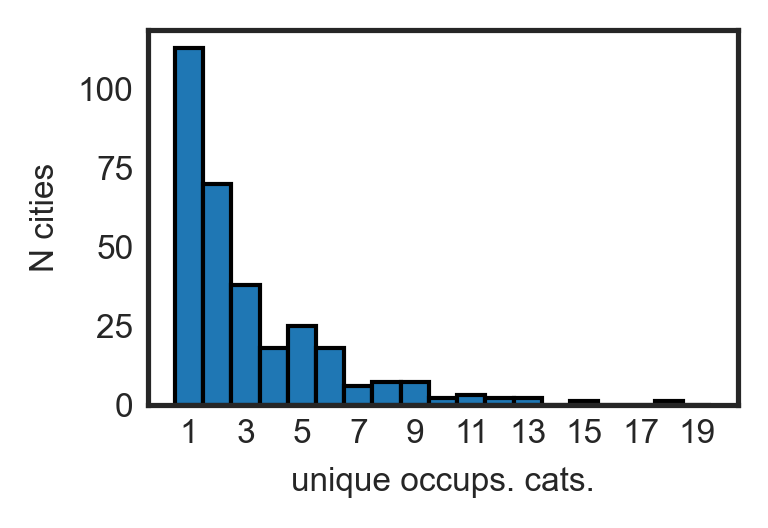

In [38]:
fig, ax = plt.subplots(figsize=(2.6, 1.8), tight_layout=True)
bins = [n+0.5 for n in range(0,20)]
roman_cities_wo["occups_cats_unique_N"].hist(ax=ax, edgecolor="black", bins=bins)
ax.set_xticks(range(1,20, 2))
ax.grid(False)
ax.set_xlabel("unique occups. cats.")
ax.set_ylabel("N cities")

In [36]:
save_figure(fig, "unique_cats_per_cities_hist")

NameError: name 'save_figure' is not defined

In [39]:
roman_cities_wo["occups_cats_unique_N"]

159     1
165     4
171     3
174     1
177     1
       ..
1297    1
1311    1
1315    1
1317    1
1321    1
Name: occups_cats_unique_N, Length: 313, dtype: int64

In [40]:
roman_cities_wo["occups_cats_list"]

159                                          [Managerial]
165     [Performing Arts, Managerial, Miscellaneous Se...
171     [Managerial, Miscellaneous Services, Manageria...
174                              [Miscellaneous Services]
177                        [Metal-Working, Metal-Working]
                              ...                        
1297                                      [Metal-Working]
1311                                      [Metal-Working]
1315                             [Managerial, Managerial]
1317                                         [Managerial]
1321                             [Managerial, Managerial]
Name: occups_cats_list, Length: 313, dtype: object

# Specialization

In [41]:
def get_cat_row_vec(cat_list):
    cat_row_vec = []
    for cat in occups_cats_labels:
        cat_row_vec.append(cat_list.count(cat))
    return np.array(cat_row_vec)

In [42]:
roman_cities_wo["occups_cats_vec"] = roman_cities_wo["occups_cats_list"].apply(get_cat_row_vec)
roman_cities_wo["occups_cats_vec"]

159     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
165     [2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...
171     [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, ...
174     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
177     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
1297    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1311    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1315    [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1317    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1321    [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: occups_cats_vec, Length: 313, dtype: object

In [43]:
def occups_cats_vec_weighted(occups_cat_vec):
    a = np.array(occups_cat_vec, dtype=float)
    a = a / sum(a)
    return a
roman_cities_wo["shares_vec"] = roman_cities_wo["occups_cats_vec"].apply(occups_cats_vec_weighted)
roman_cities_wo["shares_vec"]

159     [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
165     [0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, ...
171     [0.2222222222222222, 0.0, 0.0, 0.0, 0.0, 0.0, ...
174     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
177     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1297    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1317    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1321    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: shares_vec, Length: 313, dtype: object

In [44]:
roman_cities_wo["ZI"] = roman_cities_wo["shares_vec"].apply(max)
roman_cities_wo["ZI"]

159     1.000000
165     0.400000
171     0.666667
174     1.000000
177     1.000000
          ...   
1297    1.000000
1311    1.000000
1315    1.000000
1317    1.000000
1321    1.000000
Name: ZI, Length: 313, dtype: float64

In [48]:
roman_cities_wo["ZI_cat"] = roman_cities_wo["shares_vec"].apply(lambda x: occups_cats_labels[np.argmax(x)])

In [50]:
roman_cities_wo.sort_values("ZI", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N","occups_cats_vec", "ZI", "ZI_cat"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,occups_cats_vec,ZI,ZI_cat
159,Acholla,1.0,1.0,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,Managerial
605,Cabillonum,27.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",1.000000,Miscellaneous Services
855,Grumentum,16.0,2.0,1,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,Managerial
862,Potentia (Italia (III Lucania et Brutii)),17.0,1.0,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,Managerial
871,Aequi,26.0,1.0,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,Managerial
...,...,...,...,...,...,...,...
789,Pompeii,3297.0,56.0,11,"[9, 0, 0, 0, 2, 0, 9, 3, 0, 0, 3, 7, 10, 0, 1,...",0.178571,Miscellaneous Services
1268,Brigetio,438.0,17.0,9,"[3, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 2, 3, 0, 1, ...",0.176471,Managerial
785,Norba,106.0,12.0,8,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 2, 0, 1, ...",0.166667,Building
1271,Mursa,109.0,6.0,6,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, ...",0.166667,Managerial


In [51]:
roman_cities_wo["ZIw"] = roman_cities_wo.apply(lambda row: row["ZI"] * row["occups_N_log"], axis=1)
roman_cities_wo.sort_values("ZIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N", "occups_cats_vec", "ZI", "ZIw", "ZI_cat"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,occups_cats_vec,ZI,ZIw,ZI_cat
1287,Augusta Vindelicum,210.0,10.0,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, ...",0.900000,2.989735,Retail
873,Alba Fucentia,82.0,12.0,3,"[10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",0.833333,2.987469,Managerial
991,Roma,39882.0,1855.0,18,"[495, 18, 11, 1, 32, 110, 49, 108, 3, 24, 120,...",0.266846,2.897205,Managerial
1058,Patavium,175.0,17.0,3,"[4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.705882,2.885268,Metal-Working
332,Carmo,28.0,11.0,4,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 8, 0, 0, ...",0.727273,2.515950,Miscellaneous Services
...,...,...,...,...,...,...,...,...
631,Aquae Sextiae,24.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",1.000000,0.000000,Building
605,Cabillonum,27.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",1.000000,0.000000,Miscellaneous Services
596,Agedincum,3.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Metal-Working
583,Beda,46.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",1.000000,0.000000,Miscellaneous Services


In [52]:
# Total shares
all_occups_N = roman_cities_wo["occups_N"].sum()
index_label_sum_dict = {}
for i, cat in zip(range(len(occups_cats_labels)), occups_cats_labels):
    cat_sum = sum(roman_cities_wo["occups_cats_vec"].apply(lambda vec: vec[i]))
    cat_share = cat_sum / all_occups_N
    index_label_sum_dict[i] = [cat, cat_sum, cat_share]
index_label_sum_dict

{0: ['Managerial', 1052, 0.2384406165004533],
 1: ['Household Goods', 36, 0.008159564823209429],
 2: ['Water-Management', 14, 0.003173164097914778],
 3: ['Fuel / Raw material', 1, 0.00022665457842248413],
 4: ['Plastic Arts', 53, 0.01201269265639166],
 5: ['Education', 215, 0.04873073436083409],
 6: ['Performing Arts', 163, 0.03694469628286491],
 7: ['Clothing', 290, 0.0657298277425204],
 8: ['Unclear meaning', 4, 0.0009066183136899365],
 9: ['Food-Retail', 51, 0.011559383499546692],
 10: ['Building', 285, 0.06459655485040798],
 11: ['Retail', 301, 0.06822302810516773],
 12: ['Miscellaneous Services', 592, 0.13417951042611062],
 13: ['Death-care sector', 0, 0.0],
 14: ['Transport', 132, 0.029918404351767906],
 15: ['Food-Production', 211, 0.04782411604714415],
 16: ['Finance', 68, 0.015412511332728921],
 17: ['Glass-Working', 8, 0.001813236627379873],
 18: ['Metal-Working', 936, 0.21214868540344514]}

In [53]:
total_shares = np.array([val[2] for val in index_label_sum_dict.values()])
total_shares

array([2.38440617e-01, 8.15956482e-03, 3.17316410e-03, 2.26654578e-04,
       1.20126927e-02, 4.87307344e-02, 3.69446963e-02, 6.57298277e-02,
       9.06618314e-04, 1.15593835e-02, 6.45965549e-02, 6.82230281e-02,
       1.34179510e-01, 0.00000000e+00, 2.99184044e-02, 4.78241160e-02,
       1.54125113e-02, 1.81323663e-03, 2.12148685e-01])

In [54]:
def get_shares_weighted(vec):
    a = np.array(vec, dtype=float)
    b = total_shares
    shares_weighted =  np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    return shares_weighted

roman_cities_wo["shares_weighted_vec"] = roman_cities_wo["shares_vec"].apply(lambda vec: get_shares_weighted(vec))
roman_cities_wo["shares_weighted_vec"]

159     [4.193916349809886, 0.0, 0.0, 0.0, 0.0, 0.0, 0...
165     [1.6775665399239545, 0.0, 0.0, 0.0, 0.0, 0.0, ...
171     [0.9319814110688635, 0.0, 0.0, 0.0, 0.0, 0.0, ...
174     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
177     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1297    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [4.193916349809886, 0.0, 0.0, 0.0, 0.0, 0.0, 0...
1317    [4.193916349809886, 0.0, 0.0, 0.0, 0.0, 0.0, 0...
1321    [4.193916349809886, 0.0, 0.0, 0.0, 0.0, 0.0, 0...
Name: shares_weighted_vec, Length: 313, dtype: object

In [55]:
roman_cities_wo["RZI"] = roman_cities_wo["shares_weighted_vec"].apply(max)
roman_cities_wo["RZI"]

159     4.193916
165     5.413497
171     4.968468
174     7.452703
177     4.713675
          ...   
1297    4.713675
1311    4.713675
1315    4.193916
1317    4.193916
1321    4.193916
Name: RZI, Length: 313, dtype: float64

In [56]:
roman_cities_wo["RZI_cat"] = roman_cities_wo["shares_weighted_vec"].apply(lambda x: index_label_sum_dict[np.argmax(x)][0])
roman_cities_wo["RZI_cat"]

159                 Managerial
165            Performing Arts
171     Miscellaneous Services
174     Miscellaneous Services
177              Metal-Working
                 ...          
1297             Metal-Working
1311             Metal-Working
1315                Managerial
1317                Managerial
1321                Managerial
Name: RZI_cat, Length: 313, dtype: object

In [59]:
roman_cities_wo["RZIw"] = roman_cities_wo.apply(lambda row: row["RZI"] * row["occups_N_log"], axis=1)
roman_cities_wo.sort_values("RZIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N", "occups_cats_vec", "ZI", "ZIw", "RZI_cat", "RZI", "RZIw"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,occups_cats_vec,ZI,ZIw,RZI_cat,RZI,RZIw
659,Colonia Agrippinensis,1255.0,37.0,12,"[2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 3, 13, 6, 0, 0,...",0.351351,1.830348,Unclear meaning,29.810811,155.298029
1276,Carnuntum (1),1155.0,18.0,10,"[2, 0, 0, 0, 1, 1, 0, 2, 0, 0, 1, 1, 4, 0, 0, ...",0.222222,0.926650,Glass-Working,30.638889,127.761869
1277,Carnuntum (2),353.0,8.0,7,"[1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, ...",0.250000,0.750000,Water-Management,39.392857,118.178571
663,Andematunum,310.0,12.0,7,"[2, 0, 0, 0, 0, 0, 2, 0, 0, 3, 1, 2, 0, 0, 0, ...",0.250000,0.896241,Food-Retail,21.627451,77.533601
666,Argentoratum,214.0,5.0,3,"[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0.400000,0.928771,Plastic Arts,33.298113,77.315825
...,...,...,...,...,...,...,...,...,...,...
631,Aquae Sextiae,24.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",1.000000,0.000000,Building,15.480702,0.000000
605,Cabillonum,27.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",1.000000,0.000000,Miscellaneous Services,7.452703,0.000000
596,Agedincum,3.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,0.000000,Metal-Working,4.713675,0.000000
583,Beda,46.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",1.000000,0.000000,Miscellaneous Services,7.452703,0.000000


# Diversity

In [60]:
# again, the starting point are the shares:
roman_cities_wo["shares_vec"]

159     [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
165     [0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, ...
171     [0.2222222222222222, 0.0, 0.0, 0.0, 0.0, 0.0, ...
174     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
177     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1297    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1315    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1317    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1321    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: shares_vec, Length: 313, dtype: object

In [64]:
def get_di(shares_vec):
    a = np.array(shares_vec)
    a = a**2
    hh = sum(a) # Hirschman-Herfindahl index
    ihh = 1 / hh # inverse Hirschman-Herfindahl index
    return ihh
roman_cities_wo["DI"] = roman_cities_wo["shares_vec"].apply(get_di)

In [65]:
roman_cities_wo.sort_values("DI", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N", "occups_cats_vec", "DI"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,occups_cats_vec,DI
789,Pompeii,3297.0,56.0,11,"[9, 0, 0, 0, 2, 0, 9, 3, 0, 0, 3, 7, 10, 0, 1,...",7.919192
1268,Brigetio,438.0,17.0,9,"[3, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 2, 3, 0, 1, ...",7.410256
785,Norba,106.0,12.0,8,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 2, 0, 1, ...",7.200000
672,Mogontiacum,3065.0,59.0,12,"[10, 1, 0, 0, 0, 1, 2, 3, 0, 0, 2, 15, 8, 0, 3...",7.089613
1276,Carnuntum (1),1155.0,18.0,10,"[2, 0, 0, 0, 1, 1, 0, 2, 0, 0, 1, 1, 4, 0, 0, ...",7.043478
...,...,...,...,...,...,...
769,Ferentinum,112.0,4.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000
772,Frusino,28.0,5.0,1,"[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000
818,Ausculum,12.0,1.0,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000
833,Lupiae,38.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000


In [66]:
def get_diw(a,b):
    if b==0:
        return 0
    else:
        return a / b
roman_cities_wo["DIw"] = roman_cities_wo.apply(lambda row: get_diw(row["DI"], row['occups_N_log']), axis=1)
roman_cities_wo.sort_values("DIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N", "ZIw", "DI", "DIw"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,ZIw,DI,DIw
1271,Mursa,109.0,6.0,6,0.430827,6.0,2.321117
1045,Ateste,128.0,6.0,6,0.430827,6.0,2.321117
1283,Siscia,116.0,5.0,5,0.464386,5.0,2.153383
662,Noviomagus (Germania Inferior),103.0,5.0,5,0.464386,5.0,2.153383
1277,Carnuntum (2),353.0,8.0,7,0.750000,6.4,2.133333
...,...,...,...,...,...,...,...
631,Aquae Sextiae,24.0,1.0,1,0.000000,1.0,0.000000
605,Cabillonum,27.0,1.0,1,0.000000,1.0,0.000000
596,Agedincum,3.0,1.0,1,0.000000,1.0,0.000000
583,Beda,46.0,1.0,1,0.000000,1.0,0.000000


In [85]:
roman_cities_wo["occups_mask"] = roman_cities_wo["occups_mask"].apply(list)

In [86]:
roman_cities_wo.to_parquet("../data/roman_cities_wo.parquet")

In [88]:
roman_cities_wo.to_csv("../data/roman_cities_wo.csv")

# Correlation matrix

In [78]:
roman_cities_wo_quant = roman_cities_wo[
    roman_cities_wo["Ancient Toponym"]!="Roma"][[
   'Area', 'num_of_structures','pop_est', 'pop_est_log', 'inscr_N',  'inscr_N_log', 'occups_N', 'occups_N_log', 'occups_cats_unique_N', "ZI", 'ZIw', "RZIw",'DI',"DIw"]]

In [79]:
corr_matrix = roman_cities_wo_quant.corr()
corr_matrix = corr_matrix.round(2)
corr_matrix

,Area,num_of_structures,pop_est,pop_est_log,inscr_N,inscr_N_log,occups_N,occups_N_log,occups_cats_unique_N,ZI,ZIw,RZIw,DI,DIw
Area,1.00,0.53,0.98,0.81,0.25,0.24,0.26,0.23,0.17,-0.09,0.15,0.07,0.12,-0.08
num_of_structures,0.53,1.00,0.52,0.49,0.37,0.39,0.36,0.35,0.30,-0.19,0.26,0.15,0.25,0.06
pop_est,0.98,0.52,1.00,0.70,0.23,0.23,0.24,0.23,0.16,-0.12,0.16,0.08,0.13,-0.02
pop_est_log,0.81,0.49,0.70,1.00,0.30,0.36,0.27,0.34,0.34,-0.26,0.19,0.19,0.31,0.10
inscr_N,0.25,0.37,0.23,0.30,1.00,0.63,0.77,0.60,0.69,-0.36,0.29,0.31,0.54,0.12
inscr_N_log,0.24,0.39,0.23,0.36,0.63,1.00,0.46,0.72,0.69,-0.63,0.48,0.45,0.66,0.40
occups_N,0.26,0.36,0.24,0.27,0.77,0.46,1.00,0.62,0.66,-0.33,0.34,0.24,0.49,0.07
occups_N_log,0.23,0.35,0.23,0.34,0.60,0.72,0.62,1.00,0.89,-0.76,0.78,0.53,0.82,0.42
occups_cats_unique_N,0.17,0.30,0.16,0.34,0.69,0.69,0.66,0.89,1.00,-0.77,0.47,0.56,0.93,0.41
ZI,-0.09,-0.19,-0.12,-0.26,-0.36,-0.63,-0.33,-0.76,-0.77,1.00,-0.39,-0.54,-0.88,-0.80


<AxesSubplot:>

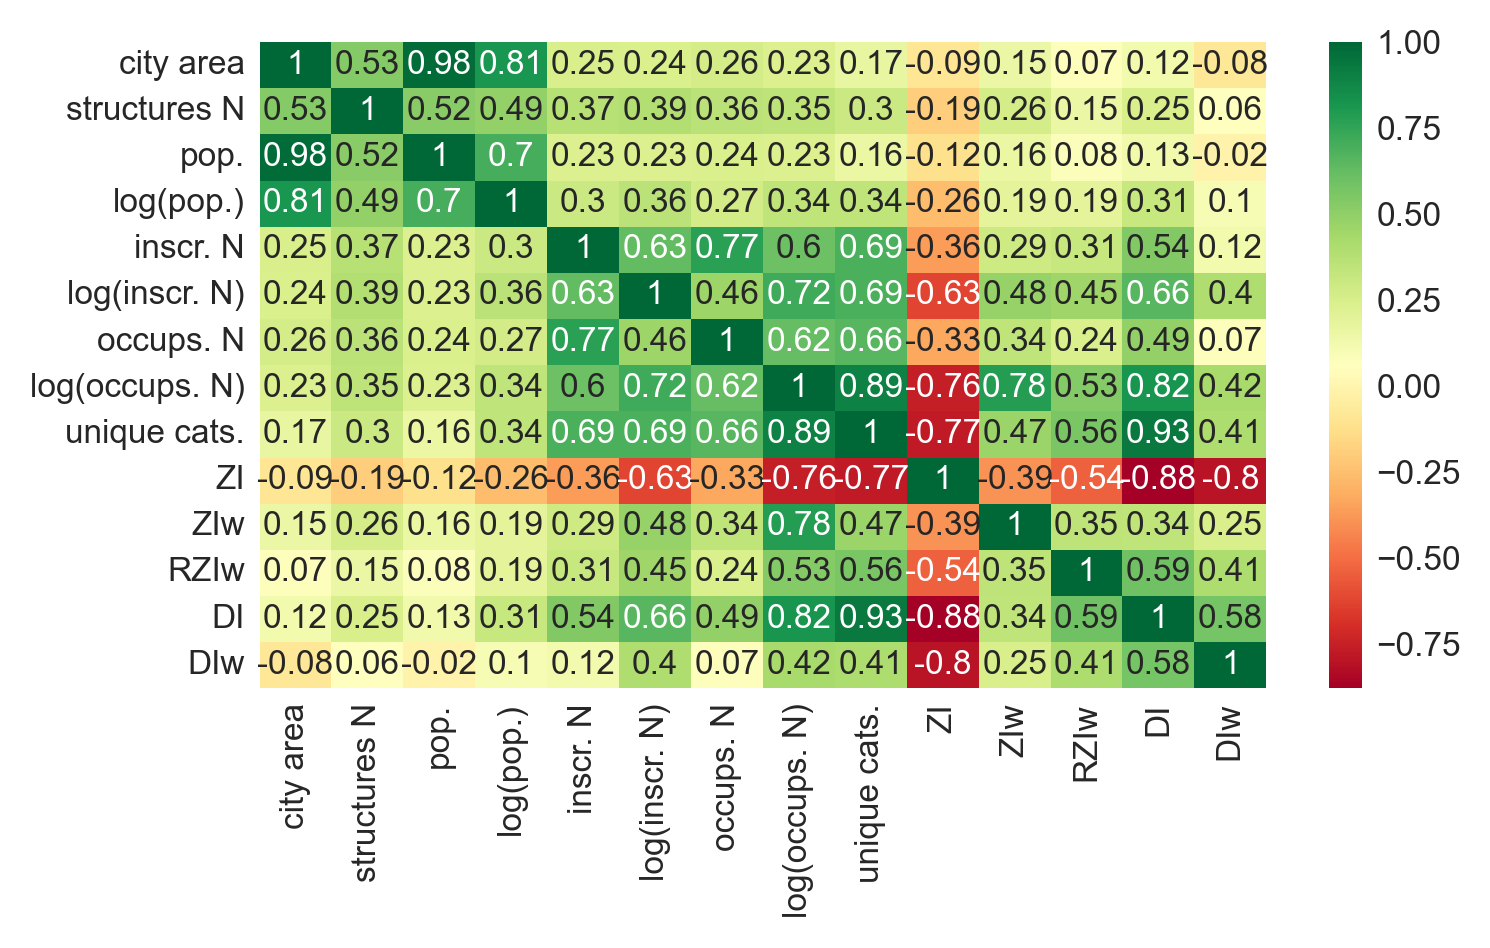

In [80]:
col_labels = ["city area", "structures N", "pop.", "log(pop.)", "inscr. N", "log(inscr. N)", "occups. N", "log(occups. N)", "unique cats.", "ZI", "ZIw", "RZIw", "DI", "DIw"]
fig,ax=plt.subplots(figsize=(5.2,3.2), tight_layout=True)
sns.heatmap(corr_matrix, xticklabels=col_labels, yticklabels=col_labels, ax=ax, cmap="RdYlGn", annot=True)

In [71]:
def get_pvalue_matrix(df):
    df = df.dropna()._get_numeric_data()
    listlist_pvalues = []
    for r in df.columns:
        row_pvalues = []
        for c in df.columns:
            try:
                row_pvalues.append(round(pearsonr(df[r], df[c])[1], 2))
            except:
                row_pvalues.append(None)
        listlist_pvalues.append(row_pvalues)
    return pd.DataFrame(listlist_pvalues, columns=df.columns, index=df.columns)

In [82]:
pvalue_matrix = get_pvalue_matrix(roman_cities_wo_quant)
pvalue_matrix

,Area,num_of_structures,pop_est,pop_est_log,inscr_N,inscr_N_log,occups_N,occups_N_log,occups_cats_unique_N,ZI,ZIw,RZIw,DI,DIw
Area,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.01,0.16,0.01,0.24,0.05,0.17
num_of_structures,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.04,0.00,0.09,0.00,0.78
pop_est,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.04,0.29,0.02,0.46,0.18,0.16
pop_est_log,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.01,0.02,0.03,0.00,0.82
inscr_N,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.12
inscr_N_log,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
occups_N,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.57
occups_N_log,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
occups_cats_unique_N,0.01,0.00,0.04,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
ZI,0.16,0.04,0.29,0.01,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00


<AxesSubplot:>

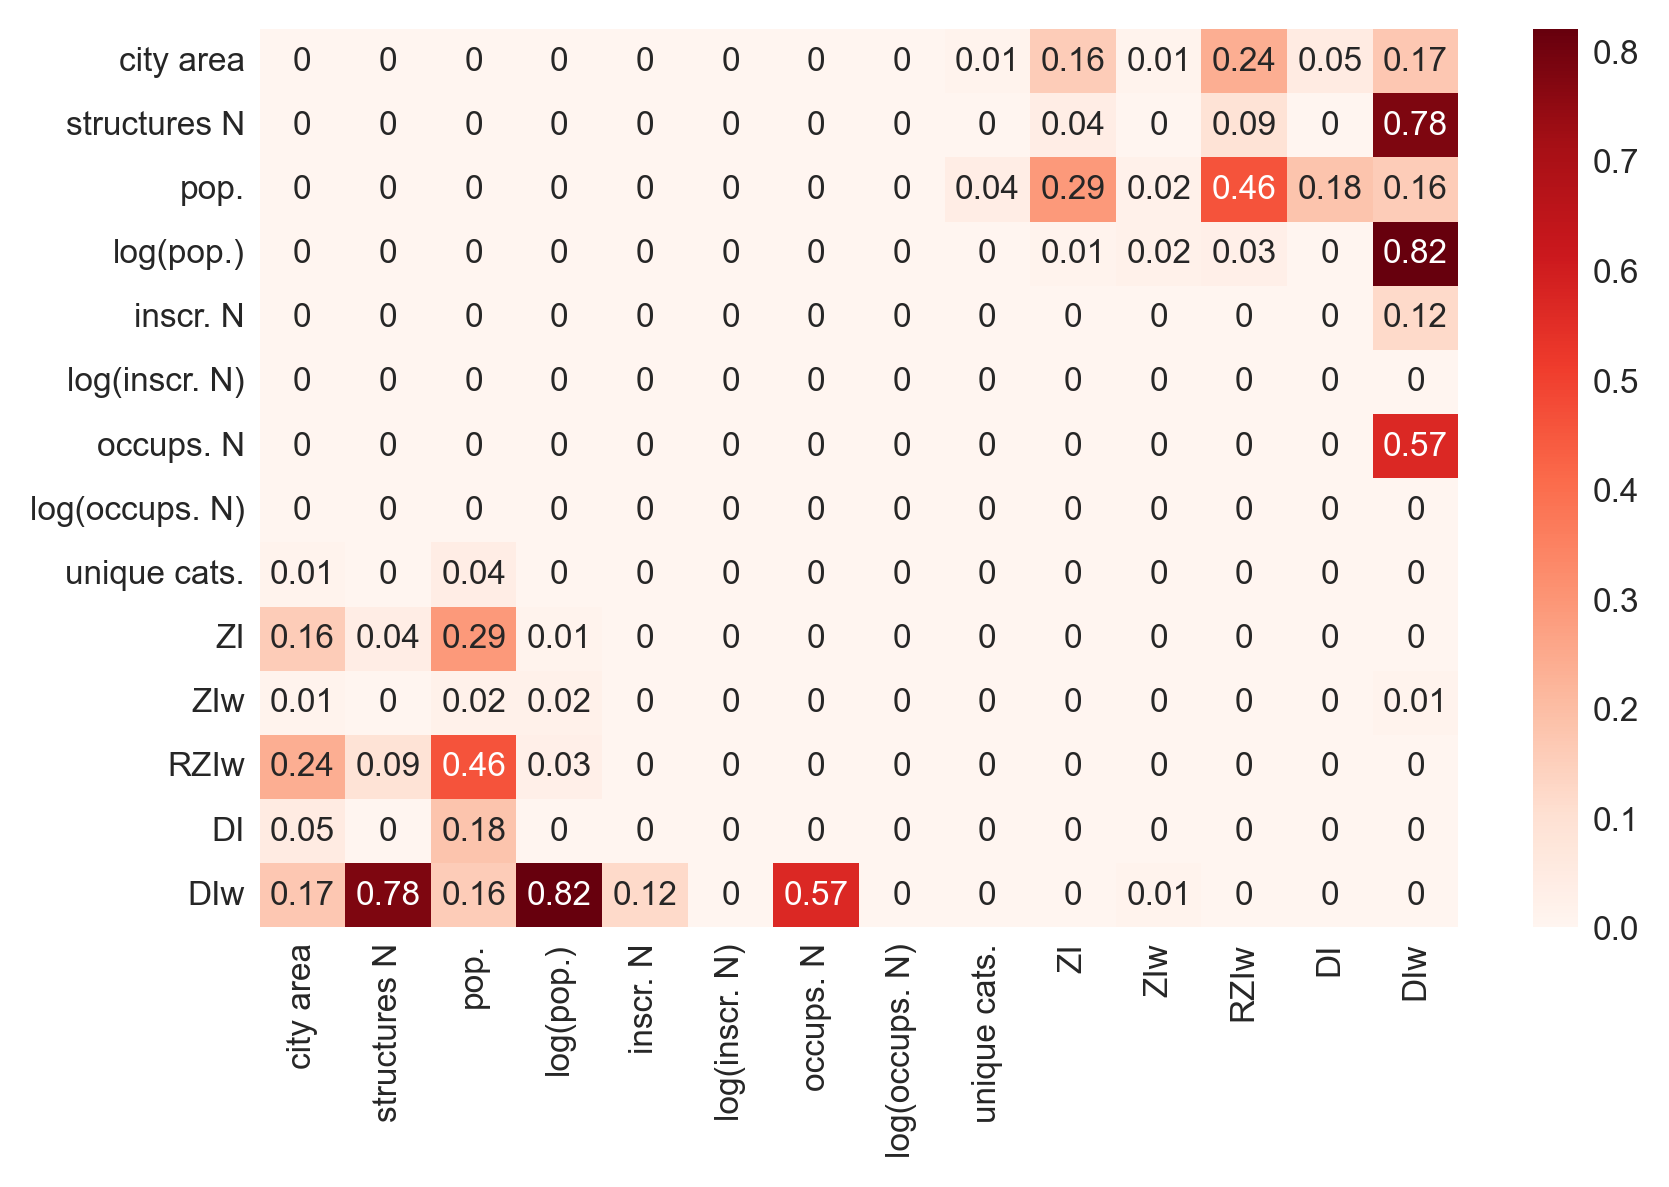

In [83]:
col_labels = ["city area", "structures N", "pop.", "log(pop.)", "inscr. N", "log(inscr. N)", "occups. N", "log(occups. N)", "unique cats.", "ZI", "ZIw", "RZIw", "DI", "DIw"]
fig,ax=plt.subplots(tight_layout=True)
sns.heatmap(pvalue_matrix, xticklabels=col_labels, yticklabels=col_labels, ax=ax, cmap="Reds", annot=True)